In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib ipympl

In [2]:
from common.transforms import get_tf_manager

tm = get_tf_manager()

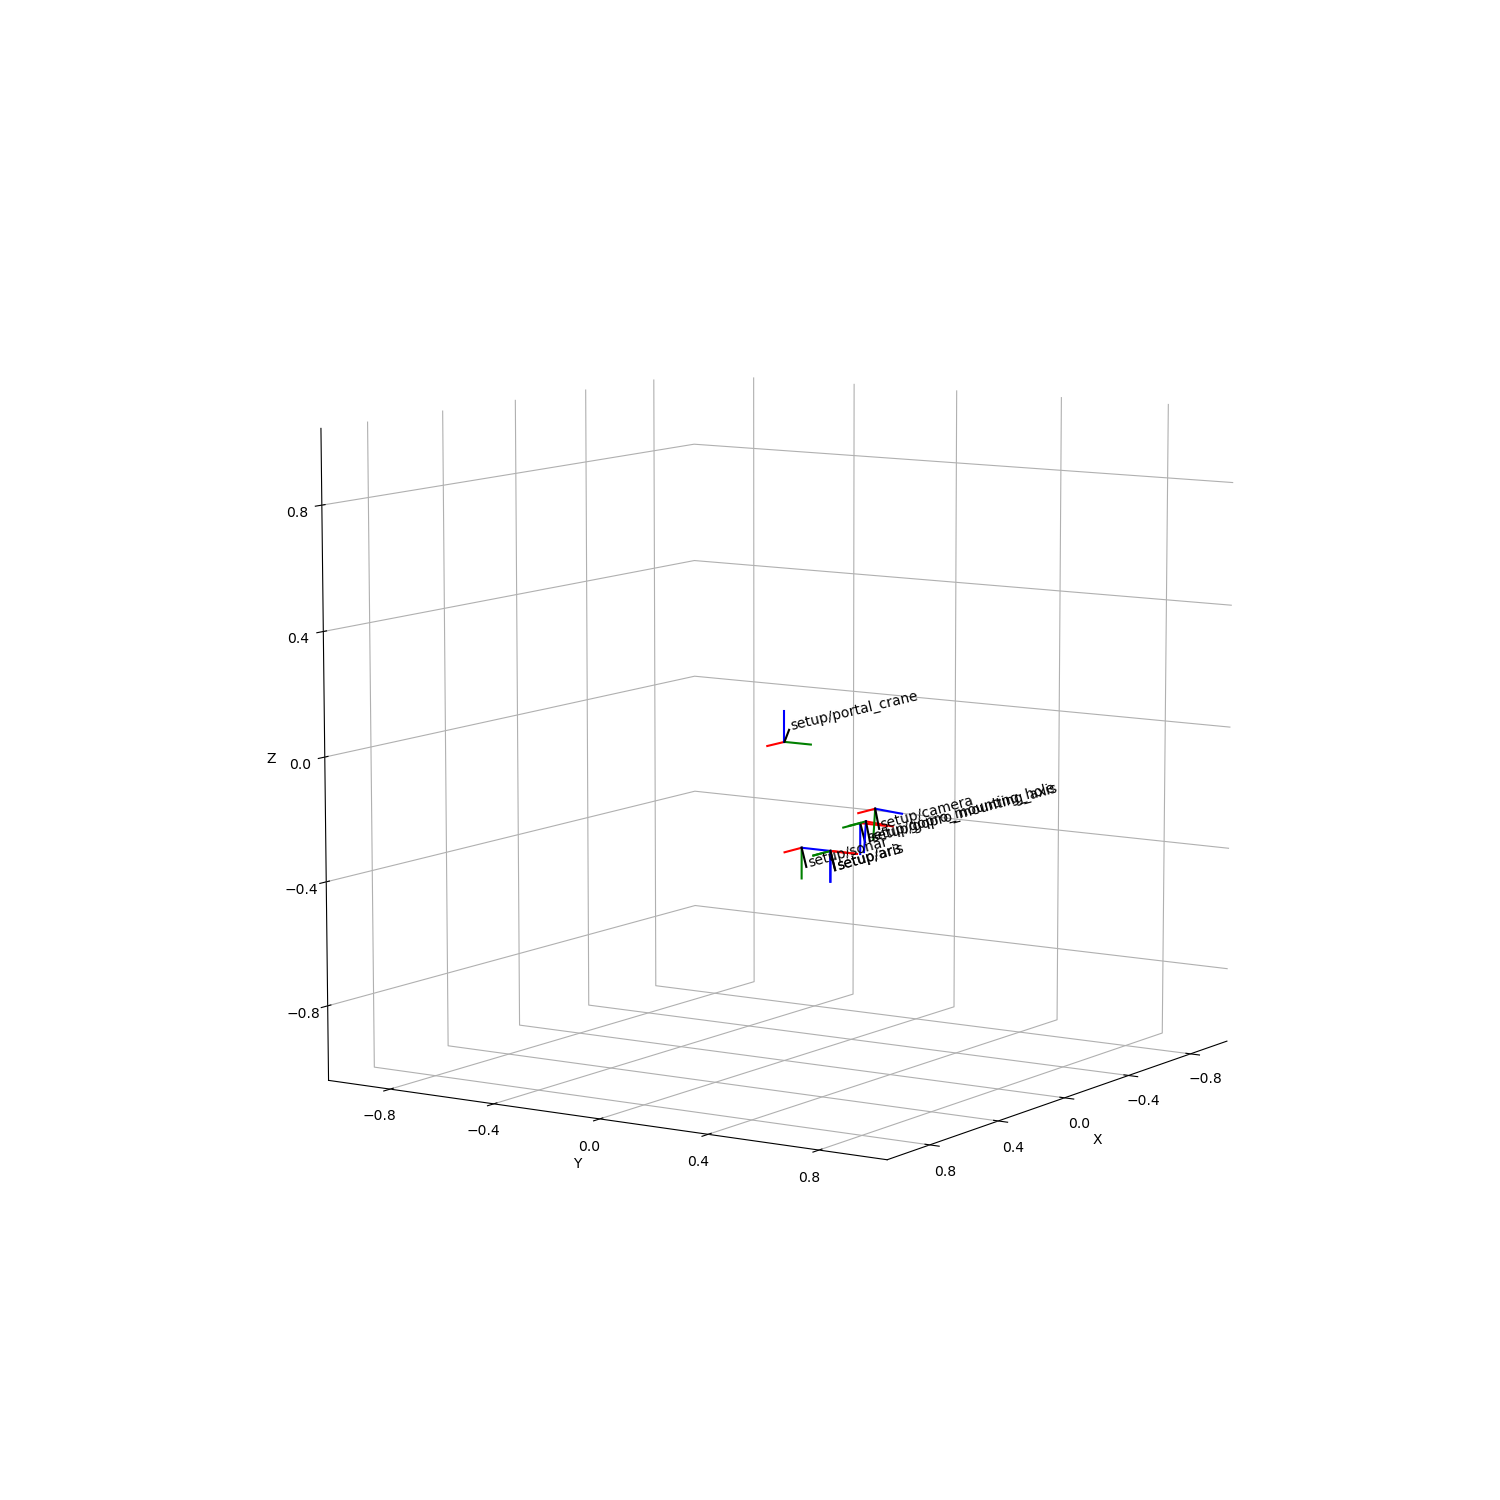

In [4]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
ax = tm.plot_frames_in("setup/portal_crane", s=0.1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.view_init(azim=33, elev=9.)
plt.show()

In [7]:

from pytransform3d import transformations as pt

transform = pt.transform_from_pq(
                np.hstack((
                    np.array([0.5, 0.5, -0.5]), 
                    np.array([1, 0, 0, 0]))))

tm.add_transform("setup/portal_crane", "world", transform)

In [8]:
tm.get_transform("setup/camera", "world").round(4)

array([[ 1.    ,  0.    , -0.    ,  0.5035],
       [-0.    , -0.0698,  0.9976,  0.8438],
       [ 0.    , -0.9976, -0.0698, -0.6849],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

## Try with real data

In [11]:
from common.config import get_config
config = get_config()

In [15]:
ROOT= '../' + config['aris_extract']
DATASET = '2023-09-20_171105'
FILENAME_ARIS_METADATA = 'aris_frame_meta.csv'
FILENAME_CRANE = 'gantry.csv'

In [17]:
df_data_aris = pd.read_csv(os.path.join(ROOT, DATASET, FILENAME_ARIS_METADATA))
df_pos = pd.read_csv(os.path.join(ROOT, DATASET, FILENAME_CRANE))
df_pos

,aris_frame_idx,x,y,z
0,622,0.165015,0.999479,-0.75
1,623,0.165042,0.998802,-0.75
2,624,0.165097,0.997552,-0.75
3,625,0.165183,0.995602,-0.75
4,626,0.165284,0.993383,-0.75
...,...,...,...,...
713,1335,2.142072,0.750056,-0.75
714,1336,2.143628,0.753152,-0.75
715,1337,2.145554,0.757040,-0.75
716,1338,2.146880,0.759994,-0.75


In [18]:
df_data_clean = df_pos
df_data_clean[['roll', 'pitch', 'yaw']] = df_data_aris[['SonarRoll', 'SonarTilt', 'SonarPan']]
# TODO: transform to the right coordinates (check roll for that)
df_data_clean['yaw'] = 180 - df_data_clean['yaw'] 
df_data_clean['pitch'] = - df_data_clean['pitch'] 
df_data_clean

,aris_frame_idx,x,y,z,roll,pitch,yaw
0,622,0.165015,0.999479,-0.75,-0.0,22.0,37.428833
1,623,0.165042,0.998802,-0.75,-0.0,22.0,37.637329
2,624,0.165097,0.997552,-0.75,-0.0,22.0,37.798172
3,625,0.165183,0.995602,-0.75,-0.0,22.0,38.058167
4,626,0.165284,0.993383,-0.75,-0.0,22.0,38.321167
...,...,...,...,...,...,...,...
713,1335,2.142072,0.750056,-0.75,-0.0,22.0,154.439167
714,1336,2.143628,0.753152,-0.75,-0.0,22.0,154.481501
715,1337,2.145554,0.757040,-0.75,-0.0,22.0,154.524834
716,1338,2.146880,0.759994,-0.75,-0.0,22.0,154.556667


In [30]:

poss = []
for index, row in df_data_clean.iterrows():
    tm.add_transform("setup/portal_crane", "world", pt.transform_from_pq(
                    np.hstack((
                    np.array(row[['x','y','z']]), 
                    np.array([1, 0, 0, 0])))))
    poss.append(tm.get_transform("setup/ar3", "world").round(6)[:3, 3])



In [24]:
from scipy.spatial.transform import Rotation as R
rots = [R.from_euler('xyz', row[['roll','pitch','yaw']], degrees=True).as_quat() for index, row in df_data_clean.iterrows()]

In [31]:
df_ar3 = pd.DataFrame()
df_ar3['aris_frame_idx'] = df_data_clean['aris_frame_idx']
df_ar3[['pos.x','pos.y', 'pos.z']] = poss
df_ar3[['rot.x','rot.y', 'rot.z', 'rot.w']] = rots
df_ar3

,aris_frame_idx,pos.x,pos.y,pos.z,rot.x,rot.y,rot.z,rot.w
0,622,0.165015,1.173479,-1.088,-0.061221,0.180721,0.314956,0.929728
1,623,0.165042,1.172802,-1.088,-0.061550,0.180609,0.316647,0.929154
2,624,0.165097,1.171552,-1.088,-0.061803,0.180523,0.317951,0.928708
3,625,0.165183,1.169602,-1.088,-0.062213,0.180382,0.320058,0.927984
4,626,0.165284,1.167383,-1.088,-0.062627,0.180239,0.322187,0.927247
...,...,...,...,...,...,...,...,...
713,1335,2.142072,0.924056,-1.088,-0.186082,0.042210,0.957307,0.217151
714,1336,2.143628,0.927152,-1.088,-0.186097,0.042141,0.957388,0.216797
715,1337,2.145554,0.931040,-1.088,-0.186113,0.042071,0.957469,0.216435
716,1338,2.146880,0.933994,-1.088,-0.186125,0.042019,0.957530,0.216169


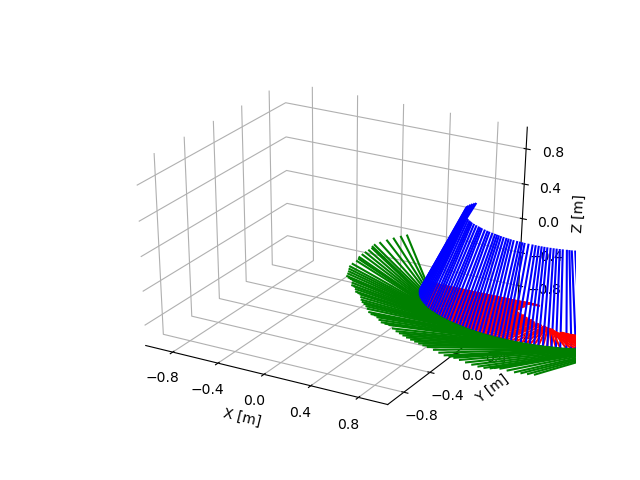

In [33]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as pytr

SCALING = 10
fig, ax = plt.subplots()
ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)
for index, row in df_ar3.iloc[::SCALING].iterrows():
    pytr.plot_transform(ax, A2B=pytr.transform_from(R.from_quat(row[['rot.x','rot.y', 'rot.z', 'rot.w']]).as_matrix(), row[['pos.x','pos.y', 'pos.z']]))
plt.show()